In [60]:
from clawpack import pyclaw
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from __future__ import absolute_import
from clawpack import riemann
#from clawpack.riemann.shallow_roe_with_efix_1D_constants import depth, momentum, num_eqn

In [61]:
def sigmoid(x):
    p = np.multiply(-1,x)
    vals = 1/(1+np.power(np.e,p))
    return vals
#sigmoid([0,1,2])

In [62]:
def entropycalc(hei,velo,num_ghost,t):
    #pass in h-b to adjust for topography
    # I think I need to pass from custom bc
    #ghost = h[:num_ghost] + h[-num_ghost:]
    #ughost = u[:num_ghost] + u[-num_ghost:]#remove BC values
    #print(h)
    hfixed = hei[num_ghost:-num_ghost]
    #newval = np.subtract(hfixed,1)
    #print(hfixed)
    ufixed = velo[num_ghost:-num_ghost] # Removing the ghost cells
    PE = np.multiply(np.multiply(hfixed,np.multiply(ufixed,ufixed) ),0.5)
    KE = np.multiply(hfixed,hfixed)
    currentEntropyArray = np.add(KE, PE) #- hghost - ughost
    summedE = np.sum(currentEntropyArray)/len(hfixed)
    global entropies
    global fullE
    global hss
    global uss
    global dts
    edgeH = [hfixed[0],hfixed[-1]]
    edgeU = [ufixed[0],ufixed[-1]]
    hss.append(np.multiply(edgeH,1))
    uss.append(np.multiply(edgeU,1))
    fullE = fullE + [currentEntropyArray]
    entropies = entropies + [summedE]
    dts = dts + [t]
    del hfixed
    del hei
    del ufixed
    del velo
    #look at two different states and subtract for flux?    
    #fornberg algorithm for finite differences method take coeffs from result. might be in matlab

In [63]:
 def custom_bc(state,dim,t,qbc,num_ghost):
    #print(qbc[0,:].shape)

    #print("que bee c: ", qbc[0,:])
    entropycalc(qbc[0,:],qbc[1,:],num_ghost,t)
    qbc[0,0] = in_height
    qbc[0,1] = in_height
    qbc[0,-1] = 0
    qbc[0,-2] = 0
    
    #qbc[0,:num_ghost] = qbc[]

    qbc[1,0] = in_velocity
    qbc[1,1] = in_velocity
    qbc[1,-1] = qbc[1,-3]
    qbc[1,-2] = qbc[1,-3]
    

In [64]:
def runclaw(in_height,in_velocity,xlower,xupper,num_points):
    claw = pyclaw.Controller()
    claw.tfinal = 100
    claw.keep_copy = True
    claw.output_format = None
    claw.num_output_times = 50
    #rs = riemann.shallow_roe_with_efix_1D
    rs = riemann.shallow_1D_py.shallow_fwave_1d

    num_eqn = 2
    solver = pyclaw.ClawSolver1D(rs)
    solver.order = 2
    solver.num_ghost = 2
    solver.num_waves=2
    solver.num_eqn=2
    #solver.limiters = pyclaw.limiters.tvd.minmod
    #solver.limiters = pyclaw.limiters.tvd.vanleer

    solver.kernel_language = 'Python'

    #solver.all_bcs = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.bc_lower[0] = pyclaw.BC.custom
    #solver.bc_upper[0] = pyclaw.BC.custom
    solver.user_bc_lower = custom_bc

    #print(solver.bc_lower)
    solver.aux_bc_lower[0] = pyclaw.BC.extrap
    solver.aux_bc_upper[0] = pyclaw.BC.extrap


    #solver.all_bcs = pyclaw.BC.periodic

    #xlower = -2.0
    #xupper = 50.0
    mx = num_points
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    state = pyclaw.State(domain,num_eqn,1)

    state.problem_data['grav'] = 1.0
    state.problem_data['sea_level'] = 0.0
    state.problem_data['dry_tolerance'] = 0.1

    xc = state.grid.x.centers
    x0=0.0


    #state.q[0,:] = hl * (xc <= x0) + hr * (xc > x0) #+ hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[0,:] = 3
    state.q[0,:] = in_height# - ((in_height/1.5)*(xc>=x0+10))  #+(1 * (xc<x0)+ (1 - xc/1) * (xc>= x0) * (xc < 1) )
    #state.q[0,:] =  in_height + (0.5 * (xc<x0)+ (0.5 - xc/10) * (xc>= x0) * (xc < 5)) -0.5
    state.q[1,:] = in_velocity #+ 0.5*(xc>= x0) - 0.25*(xc>= x0+15)   #ul * (xc <= x0) + ur * (xc > x0)

    #state.aux[0, :] = 1.0 * np.exp(-xc**2 / 0.2**2) - 1.0
    #state.aux[0,:] = sigmoid(np.multiply(-1,xc))/4
    #else:
    state.aux[0, :] = 0.5 * (xc<x0)+ (0.5 - xc/2) * (xc>= x0) * (xc < 1) #low slope IC
    #state.aux[0, :] = 1 * (xc<x0)+ (1 - xc/10) * (xc>= x0) * (xc < 10) #higher slope IC
    #state.aux[0,:] = 0.5* (xc<x0)  #step IC

    #state.aux[0,:] = 0

    #state.q[0,:] = hl * (xc <= x0 - obj_size) + hr * (xc > x0+obj_size) + hc*(x0-obj_size < xc)*(xc < x0+obj_size )
    #state.q[1,:] = hl*ul * (xc <= x0) + hr*ur * (xc > x0)

    plt.plot(xc,state.q[0,:])
    plt.plot(xc,state.aux[0,:])
    plt.plot(xc,state.q[1,:])

    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.run()
    return [claw.frames,xc]

In [65]:
#plt.plot(xc,state.q[0,:])
#plt.plot(xc,state.aux[0,:])
#plt.plot(xc,state.q[1,:])

In [66]:
#claw.solution = pyclaw.Solution(state,domain)
#claw.solver = solver
#claw.run()

2019-03-23 19:42:01,889 WARNING CLAW: The custom boundary condition
                                        function signature has been changed.
                                        The previous signature will not be
                                        supported in Clawpack 6.0.  Please see 
                                        http://www.clawpack.org/pyclaw/solvers.html#change-to-custom-bc-function-signatures
                                        for more information.
2019-03-23 19:42:01,892 INFO CLAW: Solution 0 computed for time t=0.000000
2019-03-23 19:42:02,042 INFO CLAW: Solution 1 computed for time t=2.000000
2019-03-23 19:42:02,193 INFO CLAW: Solution 2 computed for time t=4.000000
2019-03-23 19:42:02,354 INFO CLAW: Solution 3 computed for time t=6.000000
2019-03-23 19:42:02,516 INFO CLAW: Solution 4 computed for time t=8.000000
2019-03-23 19:42:02,686 INFO CLAW: Solution 5 computed for time t=10.000000
2019-03-23 19:42:02,837 INFO CLAW: Solution 6 computed for time

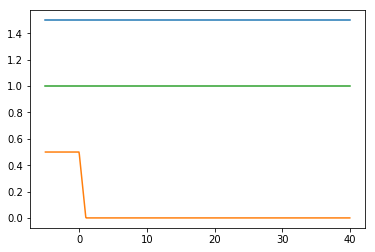

In [67]:
#from clawpack.visclaw import ianimate
#ianimate.ianimate(claw)

#testframe = claw.frames[50]
#testframe2 = claw.frames[1]
#np.mean(testframe.q[0,:]-testframe2.q[0,:])
in_height = 1.5
in_velocity = 1.0
xlower = -5
xupper = 40
num_points=800
entropies = []
fullE = []
hss = []
uss = []
dts = []
solns,xc = runclaw(in_height, in_velocity, xlower, xupper,num_points)

In [68]:
#in_height = 1.75
#in_velocity = 2
#solns = runclaw(in_height, in_velocity)
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

frame = solns[0]
depth = frame.q[0,:]
line1, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], lw=2)
line3, = ax.plot([], [], lw=2)
plt.legend(['Fluid height','Fluid velocity', 'Topography'])
plt.xlabel('X')
plt.ylabel('h, u, b')
ax.set_xlim(xlower,xupper)
ax.set_ylim(-5,5)
def fplot(frame_number):
    frame = solns[frame_number]
    depth = frame.q[0,:]
    velocity = frame.q[1,:]
    b = frame.aux[0,:]
    line1.set_data(xc,depth)
    line2.set_data(xc,velocity)
    line3.set_data(xc,b)
    return line1,

anim = animation.FuncAnimation(fig, fplot, frames=len(solns), interval=50, repeat=False) #len(claw.frames) can be put in frames=
plt.close()
HTML(anim.to_jshtml())

In [69]:
#test = solns[15]
#test.q[0,:]

In [83]:
h = hss
u = uss
#def shockcalc(entropy,u,h,dts):
eFluxIn = [None]*(len(h)-1)
eFluxOut = [None]*(len(h)-1)
#c = 1 #constant to relate mass to height of water #can factor out since it's in all terms
#entropies[-5:-1]
#c(1/2 dh/dt u^2 + h u du/dt + 2gh dh/dt)
integratedE = 0.0
for ii in range(1,len(hss)):
    #print(ii)
    dhdt = (h[ii-1][0] -h[ii][0])/(dts[ii-1]-dts[ii])
    dudt = (u[ii-1][0] -u[ii][0])/(dts[ii-1]-dts[ii])
    
    eFluxIn[ii-1] =  (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)
    eFluxOut[ii-1] = (0.5*dhdt*(u[ii][-1])**2 + h[ii][-1]*u[ii][-1]*dudt + 2*h[ii][-1]*dhdt)
    
    if dts[ii-1]==dts[ii]:
        eFluxIn[ii-1] = 0.0
        eFluxOut[ii-1] = 0.0
for ii in range(1,len(h)-1):
    integratedE = integratedE + entropies[ii] - (in_height-h[ii][0]) - (in_velocity-u[ii][0]) - entropies[0]
    #integratedE = integratedE + entropies[ii] - eFluxIn[ii] + eFluxOut[ii] -entropies[0]

/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/max/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [84]:
h[1][0]
#print(np.max(eFluxOut))
#print(np.max(eFluxIn))
#filter(lambda v: v==v, eFluxOut)
#eFluxOut = eFluxOut[np.logical_not(np.isnan(eFluxOut))]
#eFluxOut = eFluxOut[~np.isnan(eFluxOut)]

1.5

In [85]:
#eFluxIn = [None]*(len(h)-1)
#dhdt = (h[ii-1][0] -h[ii][0])/(dts[0]-dts[1])
#dudt = (u[ii-1][0] -u[ii][0])/(dts[0]-dts[1])
#print(dudt)
#eFluxIn[0] = (0.5*dhdt*(u[ii][0])**2 + h[ii][0]*u[ii][0]*dudt + 2*h[ii][0]*dhdt)

In [86]:
print(integratedE)

-127.832393429


In [82]:
print(entropies[-2] - eFluxIn[-2] - eFluxOut[-2] -entropies[0])

0.0209496783448


In [75]:
np.sum(np.subtract(h,1.5))

-1112.2896952423175

In [76]:
np.sum(np.subtract(u,1))

1158.5384300680125

In [77]:
np.sum(u)

11116.538430068013